In [66]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import scipy

In [67]:
def matrix_psd(X, fs, nperseg, ancho_banda):
    M, N = X.shape  # X es de tamaño M x N (M observaciones, N muestras)
    
    # Calcular tamaño de la FFT basado en el ancho de banda deseado
    n_fft = int(fs / ancho_banda)
    
    # Inicializar la matriz para almacenar los PSD
    Psd_m = np.zeros((M, n_fft // 2 + 1))  # Cada PSD tiene (n_fft // 2 + 1) puntos de frecuencia
    
    # Loop para calcular el PSD de cada observación
    for i in range(M):
        # Calcular el PSD usando el método de Welch para cada observación (fila de X)
        f, psd = scipy.signal.welch(X[i], fs, nperseg=nperseg, nfft=n_fft)
        Psd_m[i] = psd  # Almacenar el PSD en la matriz
    
    return f, Psd_m

# Extract sample number using regex and sort by sample number
def extract_sample_number(file_name):
    match = re.search(r'sample #(\d+)', file_name)
    if match:
        return int(match.group(1))
    # Return a large number to push files without sample numbers to the end
    return float('inf')

In [68]:
try:
    path_file_folder = r'C:\Samples-Hack-RF'

    # List all files in the folder
    file_list = os.listdir(path_file_folder)

    # Sort files by sample number
    sorted_file_list = sorted(file_list, key=extract_sample_number)

    # Initialize data matrix based on the sorted file list
    exploration_path = os.path.join(path_file_folder, sorted_file_list[0])
    data_exploration = np.load(exploration_path)
    data_matrix = np.zeros((len(sorted_file_list), data_exploration.shape[0]))

    # Load all files into data_matrix
    for pos, file_name in enumerate(sorted_file_list):
        full_path = os.path.join(path_file_folder, file_name)
        data = np.load(full_path)
        #print(f"Loading {file_name} (sample #{extract_sample_number(file_name)}), shape = {data.shape}")
        data_matrix[pos] = data

    print("Data matrix loading complete.")

except FileNotFoundError as fnf_error:
    print(f"Error: {fnf_error}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Data matrix loading complete.


C:\Users\david\AppData\Local\Temp\ipykernel_4124\3712461269.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
  data_matrix[pos] = data


In [69]:
# Parámetros
fs = 20e6  # Frecuencia de muestreo en Hz (20 MHz)
time_sample = 0.01  # Duración total en segundos
num_samples = int(fs * time_sample)
t = np.linspace(0, time_sample, num_samples)
nperseg = 1024
ancho_banda = 200e3
f, Psd_m = matrix_psd(data_matrix, fs, nperseg, ancho_banda)

print(f"Frecuencias: {f}")
print(f"Matriz PSD (M observaciones x Frecuencias): {Psd_m.shape}")

M = 28 N = 200000


ValueError: nfft must be greater than or equal to nperseg.

In [57]:
# 2. Descomposición SVD
U, Sigma, Vt = np.linalg.svd(psd_matrix, full_matrices=False)

# 3. Calcular el vector v para cada canal y encontrar el canal que minimiza v
def calculate_v(k, Sigma):
    return np.sum(Sigma[:k] ** 2) / np.sum(Sigma ** 2)

v_values = [calculate_v(k, Sigma) for k in range(1, len(Sigma) + 1)]
c = np.argmin(v_values)  # Índice del canal con menor presencia de señal

print(f"El canal con menor presencia de señal es: c = {c + 1}")

# 4. Calcular el umbral λ para el canal c
P_c = np.mean(psd_matrix[c])  # Promedio de las observaciones del canal c
lambda_threshold = P_c + 3

print(f"Umbral λ: {lambda_threshold}")

El canal con menor presencia de señal es: c = 1
Umbral λ: 3.000000000004218


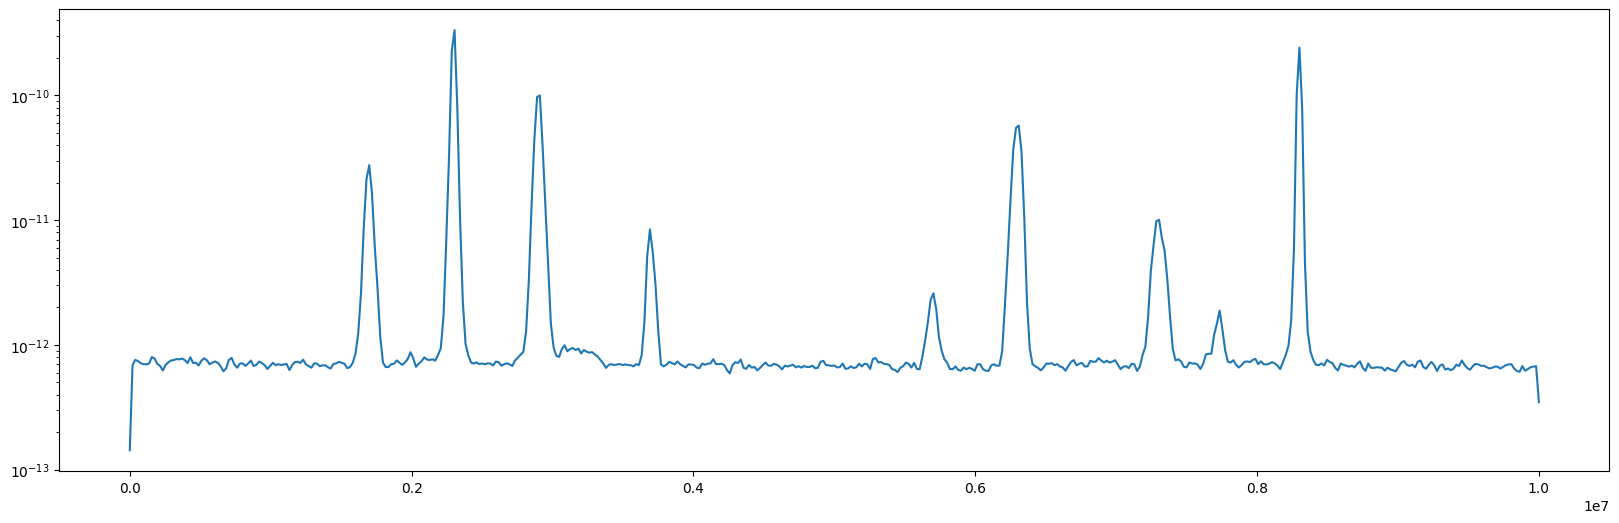

In [58]:
plt.figure(figsize=(20,6))
plt.semilogy(f, psd_matrix[20])
plt.show()

# Método 1. Tabla de estándares
## ITU-R P.372-17 (Pag 4)

$$
P_n = F_a + B - 204 \, \text{dBW}
$$

# (Pag 101)

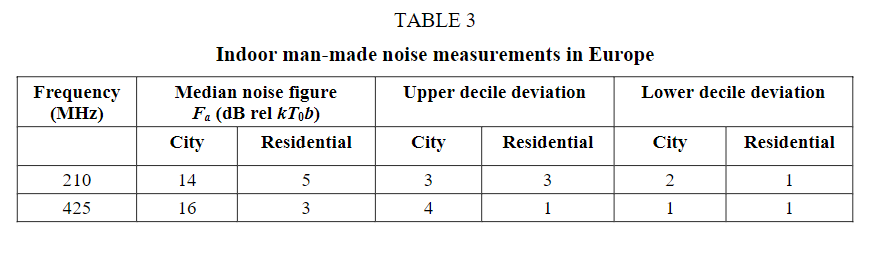




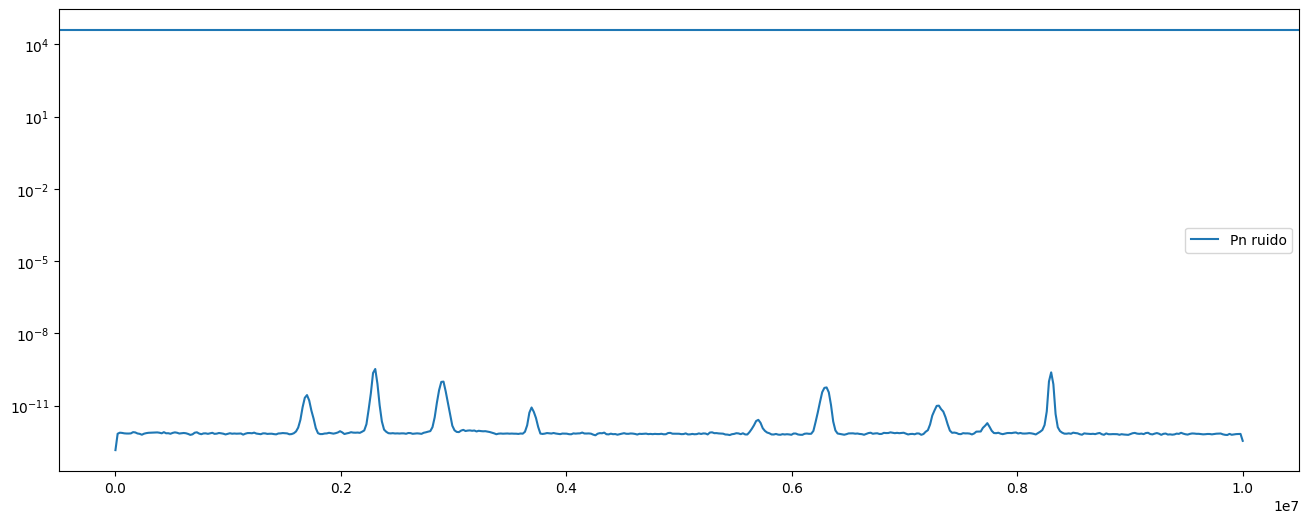

In [59]:
B = fs/(nperseg//2 + 1) #Ancho de banda del ruido
Fa = 14 #dB de la Tabla, caso Ciudad, 210MHz
k = 1.38e-23 #Boltzman constant
To = 290
Pn = Fa + B - 10*np.log10(k*To)

plt.figure(figsize=(16,6))
plt.semilogy(f, psd_matrix[20])
plt.axhline(y=Pn, label='Pn ruido')
plt.legend()
plt.show()

# Método 2.
## ITU-RPy

ANT500

Antena: https://www.greatscottgadgets.com/ant500/

- 50 ohm general purpose antenna
- operating frequency: 75 MHz to 1 GHz
- telescopic antenna
- Length is configurable from 20 cm to 88 cm

Coordenadas Unal Manizales Nubia = 5°01'44.8"N, 75°28'19.8"W
HackRF-one operating freq: 1 MHz to 6 GHz 

frecuencia objetivo = 108MHz este caso

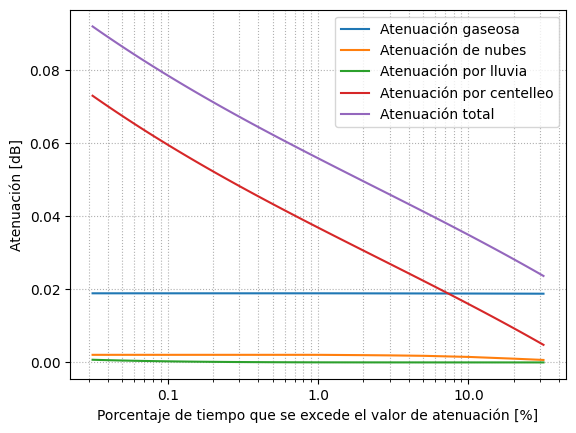

In [60]:
import itur
import astropy.units as u
from matplotlib.ticker import ScalarFormatter

# Coordenadas de la estación terrestre
lat_GS = 5.0291
lon_GS = -75.4722

# Coordenadas del satélite GEO (77 W)
lat_sat = 0
lon_sat = -77
h_sat = 35786 * u.km

# Calcular el ángulo de elevación
el = itur.utils.elevation_angle(h_sat, lat_sat, lon_sat, lat_GS, lon_GS)

# Parámetros del enlace
fr = 1 * u.GHz    # Frecuencia del enlace
D = 0.88 * u.m       # Diámetro de antena

# Vector de indisponibilidades
unavailabilities = np.logspace(-1.5, 1.5, 100)

# Calcular las atenuaciones atmosféricas
A_g, A_c, A_r, A_s, A_t = [], [], [], [], []
for p in unavailabilities:
    a_g, a_c, a_r, a_s, a_t = itur.atmospheric_attenuation_slant_path(lat_GS, lon_GS, fr, el, p, D, return_contributions=True)
    A_g.append(a_g.value)
    A_c.append(a_c.value)
    A_r.append(a_r.value)
    A_s.append(a_s.value)
    A_t.append(a_t.value)

# Graficar resultados
ax = plt.subplot(1,1,1)
ax.semilogx(unavailabilities, A_g, label='Atenuación gaseosa')
ax.semilogx(unavailabilities, A_c, label='Atenuación de nubes')
ax.semilogx(unavailabilities, A_r, label='Atenuación por lluvia')
ax.semilogx(unavailabilities, A_s, label='Atenuación por centelleo')
ax.semilogx(unavailabilities, A_t, label='Atenuación total')

ax.xaxis.set_major_formatter(ScalarFormatter())
ax.set_xlabel('Porcentaje de tiempo que se excede el valor de atenuación [%]')
ax.set_ylabel('Atenuación [dB]')
ax.grid(which='both', linestyle=':')
plt.legend()
plt.show()

# Método 3
## CONGRESO INTERNACIONAL DE INVESTIGACIÓN E INNOVACIÓN 2018” Multidisciplinario 
- 19 y 20 de abril de 2018, Cortazar, Guanajuato, México 
- ISSN 2448-6035




In [61]:
# 2. Descomposición SVD
U, Sigma, Vt = np.linalg.svd(psd_matrix, full_matrices=False)

# 3. Calcular el vector v para cada canal y encontrar el canal que minimiza v
def calculate_v(k, Sigma):
    return np.sum(Sigma[:k] ** 2) / np.sum(Sigma ** 2)

v_values = [calculate_v(k, Sigma) for k in range(1, len(Sigma) + 1)]
c = np.argmin(v_values)  # Índice del canal con menor presencia de señal

print(f"El canal con menor presencia de señal es: c = {c + 1}")

# 4. Calcular el umbral λ para el canal c
P_c = np.mean(psd_matrix[c])  # Promedio de las observaciones del canal c
lambda_threshold = P_c + 3

print(f"Umbral λ: {lambda_threshold}")

El canal con menor presencia de señal es: c = 1
Umbral λ: 3.000000000004218
